Data set: flame.mat | Samples: 240
Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.


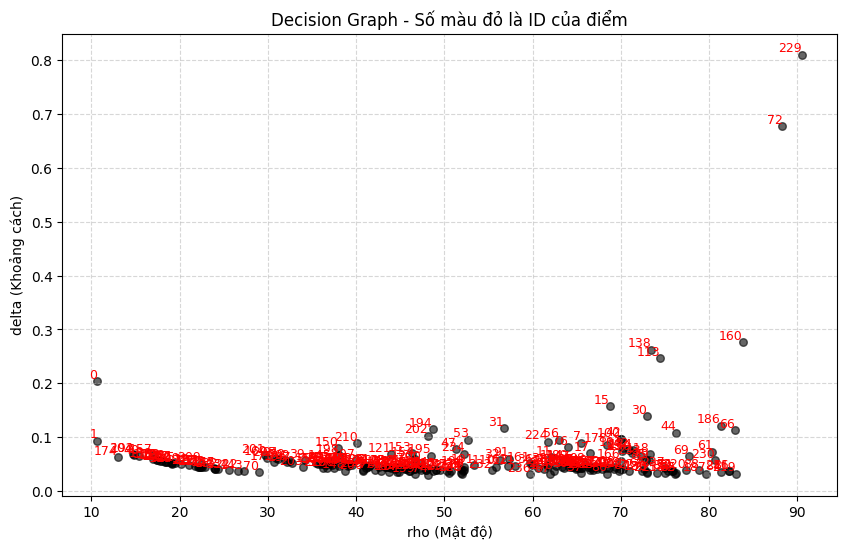

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  229, 72


Các tâm cụm đã chọn: [229, 72]


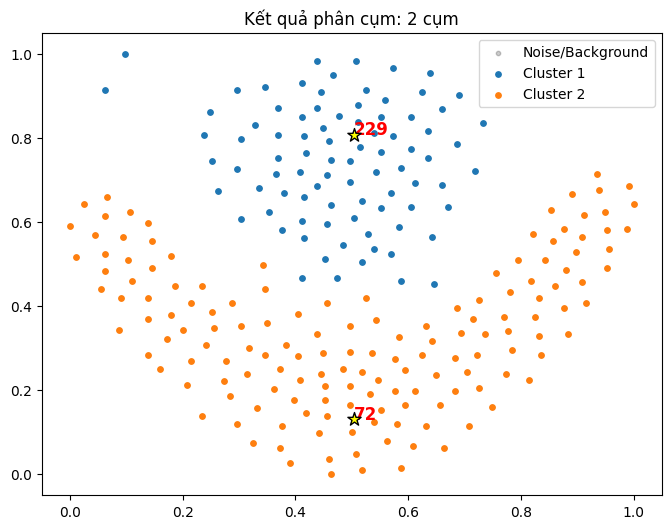

Thời gian chạy: 18.3731s


In [28]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # ==================== TÍNH MẬT ĐỘ CỤC BỘ ====================
    rho = WMKNNDensity(dist, K)

    # ==================== TÍNH DELTA ====================
    delta, neighh = compute_delta(dist, rho)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
DataName = 'flame.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = 3
datamat = scipy.io.loadmat(DataName)
data = datamat['attribute'].tolist()
# Chuẩn hóa
data, model = libsvm_scale(data, 0, 1)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data] for row_i in data]

print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


Data set: pathbased.mat | Samples: 300
Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.


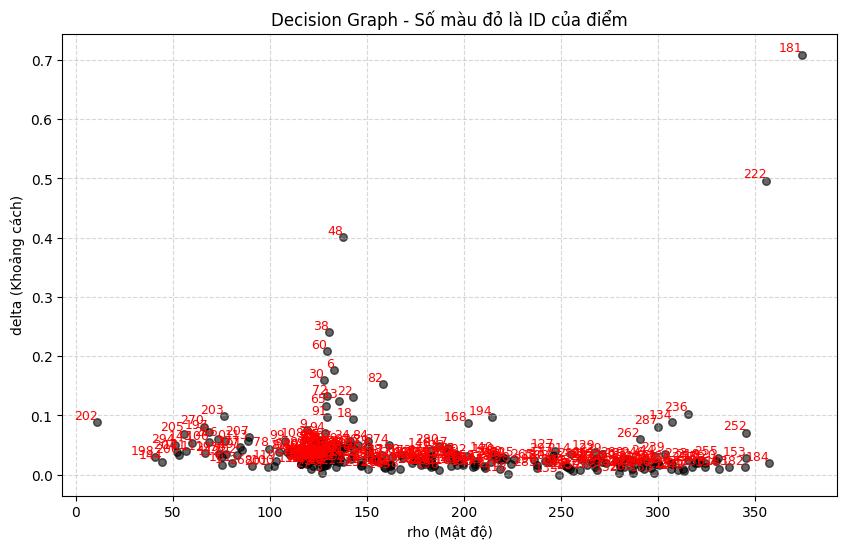

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  181, 222, 48


Các tâm cụm đã chọn: [181, 222, 48]


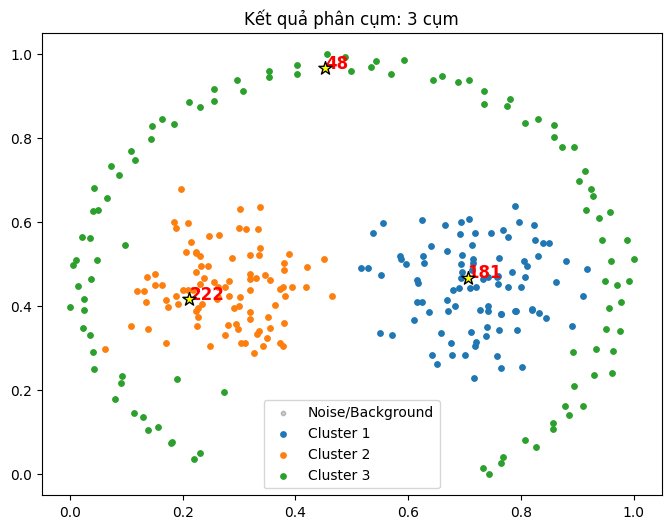

Thời gian chạy: 12.0292s


In [18]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # ==================== TÍNH MẬT ĐỘ CỤC BỘ ====================
    rho = WMKNNDensity(dist, K)

    # ==================== TÍNH DELTA ====================
    delta, neighh = compute_delta(dist, rho)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
DataName = 'pathbased.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = 10
datamat = scipy.io.loadmat(DataName)
data = datamat['attribute'].tolist()
# Chuẩn hóa
data, model = libsvm_scale(data, 0, 1)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data] for row_i in data]

print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


Data set: Aggregation.mat | Samples: 788
Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.


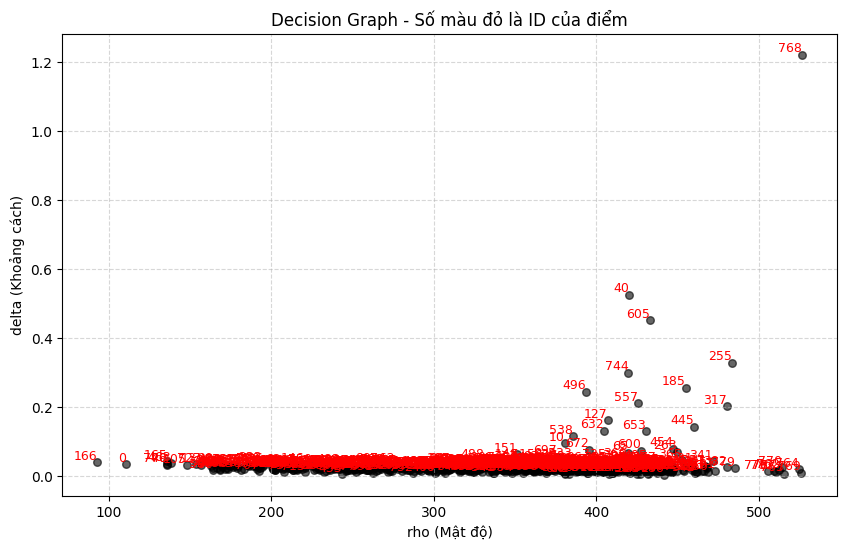

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  768, 40, 605, 255, 744, 185, 496


Các tâm cụm đã chọn: [768, 40, 605, 255, 744, 185, 496]


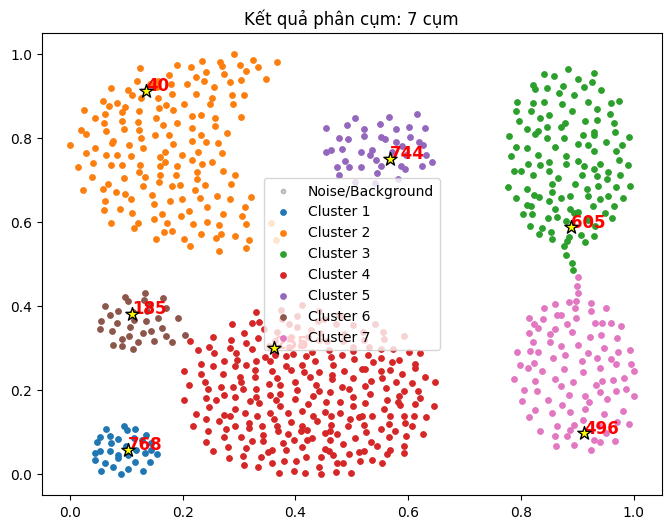

Thời gian chạy: 66.0007s


In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # ==================== TÍNH MẬT ĐỘ CỤC BỘ ====================
    rho = WMKNNDensity(dist, K)

    # ==================== TÍNH DELTA ====================
    delta, neighh = compute_delta(dist, rho)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
DataName = 'Aggregation.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = 16
datamat = scipy.io.loadmat(DataName)
data = datamat['attribute'].tolist()
# Chuẩn hóa
data, model = libsvm_scale(data, 0, 1)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data] for row_i in data]

print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


Data set: spiral.mat | Samples: 312
Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.


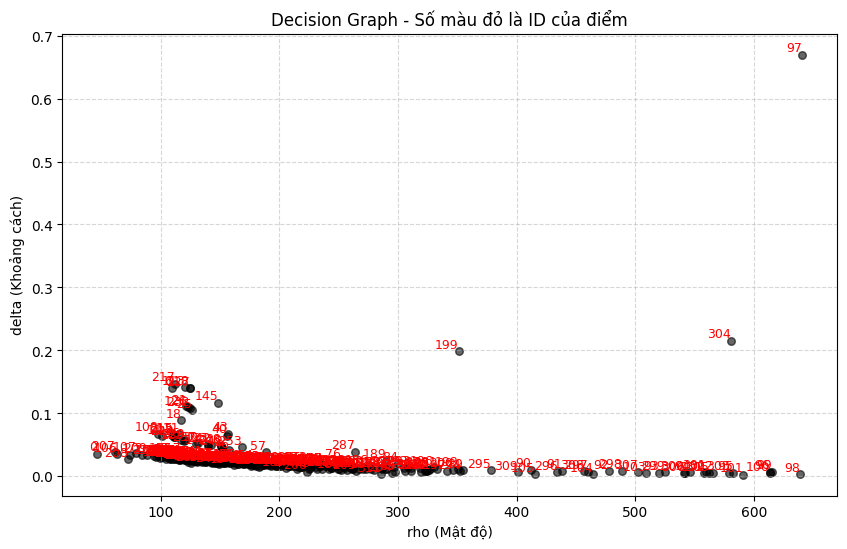

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  97, 304, 199


Các tâm cụm đã chọn: [97, 304, 199]


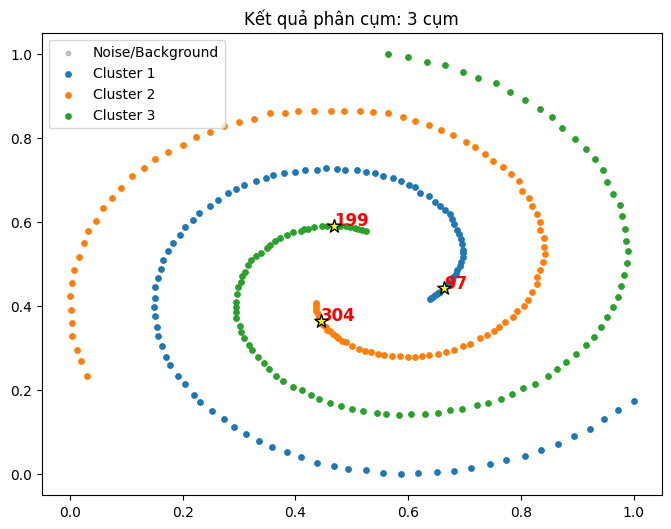

Thời gian chạy: 36.0686s


In [24]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # ==================== TÍNH MẬT ĐỘ CỤC BỘ ====================
    rho = WMKNNDensity(dist, K)

    # ==================== TÍNH DELTA ====================
    delta, neighh = compute_delta(dist, rho)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
DataName = 'spiral.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = 15
datamat = scipy.io.loadmat(DataName)
data = datamat['attribute'].tolist()
# Chuẩn hóa
data, model = libsvm_scale(data, 0, 1)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data] for row_i in data]

print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


Data set: compound.mat | Samples: 399
Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.


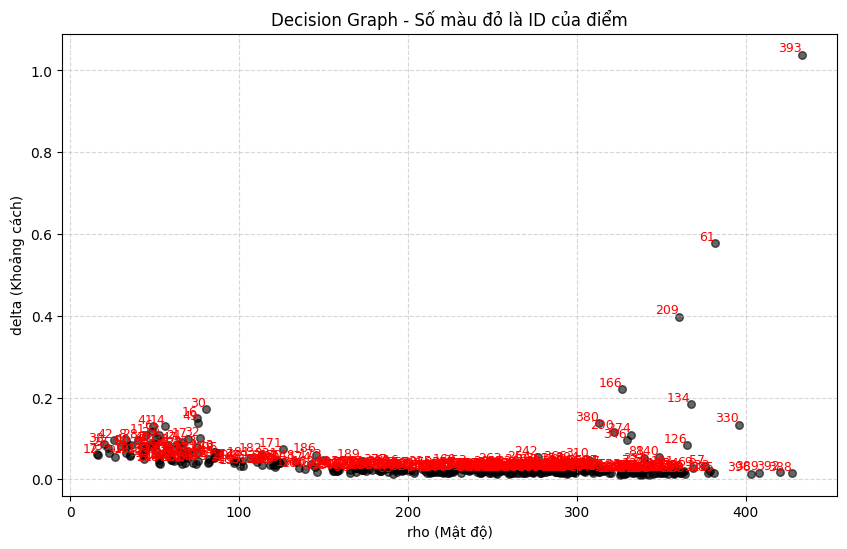

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  393, 61, 209, 166, 30, 380


Các tâm cụm đã chọn: [393, 61, 209, 166, 30, 380]
--------------------------------------------------
ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM (SILHOUETTE)
Silhouette trung bình: 0.1426


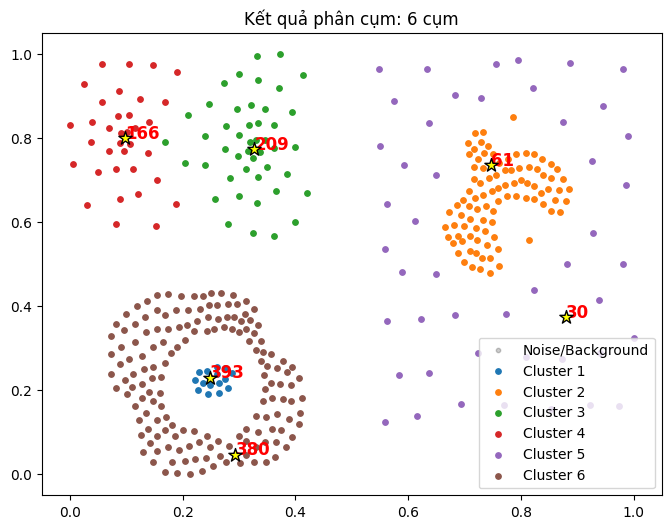

Thời gian chạy: 33.3706s


In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # ==================== TÍNH MẬT ĐỘ CỤC BỘ ====================
    rho = WMKNNDensity(dist, K)

    # ==================== TÍNH DELTA ====================
    delta, neighh = compute_delta(dist, rho)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

def silhouette_score_manual(dist, labels):
    """
    Tính Silhouette cho phân cụm
    dist   : ma trận khoảng cách NxN
    labels : nhãn cụm (1-based), 0 nếu noise
    """
    N = len(labels)
    unique_clusters = sorted(set(l for l in labels if l > 0))
    s = [0.0] * N

    for i in range(N):
        ci = labels[i]

        # Bỏ qua noise hoặc điểm chưa gán
        if ci == 0:
            s[i] = 0
            continue

        # ===== a(i): khoảng cách TB trong cùng cụm =====
        same_cluster = [j for j in range(N) if labels[j] == ci and j != i]
        if same_cluster:
            a_i = sum(dist[i][j] for j in same_cluster) / len(same_cluster)
        else:
            a_i = 0.0

        # ===== b(i): khoảng cách TB nhỏ nhất tới cụm khác =====
        b_i = float("inf")
        for c in unique_clusters:
            if c == ci:
                continue
            other_cluster = [j for j in range(N) if labels[j] == c]
            if not other_cluster:
                continue
            avg_dist = sum(dist[i][j] for j in other_cluster) / len(other_cluster)
            if avg_dist < b_i:
                b_i = avg_dist

        # ===== s(i) theo đúng công thức Silhouette =====
        if a_i < b_i:
            s[i] = 1 - a_i / b_i
        elif a_i > b_i:
            s[i] = b_i / a_i - 1
        else:
            s[i] = 0

    # Silhouette trung bình (chỉ tính điểm có nhãn)
    valid_s = [v for i, v in enumerate(s) if labels[i] > 0]
    silhouette_mean = sum(valid_s) / len(valid_s) if valid_s else 0

    return s, silhouette_mean

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
DataName = 'compound.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = 10
datamat = scipy.io.loadmat(DataName)
data = datamat['attribute'].tolist()
# Chuẩn hóa
data, model = libsvm_scale(data, 0, 1)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data] for row_i in data]

print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)
# ==================== ĐÁNH GIÁ SILHOUETTE ====================
sil_values, sil_mean = silhouette_score_manual(dist, cl)

print("-" * 50)
print("ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM (SILHOUETTE)")
print(f"Silhouette trung bình: {round(sil_mean, 4)}")

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


Data set: smile.mat | Samples: 266
Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.


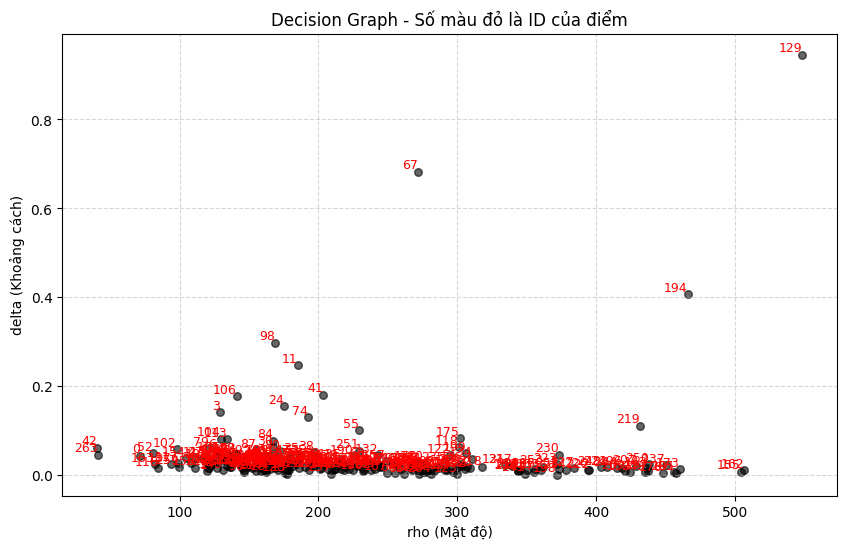

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  129, 67, 194


Các tâm cụm đã chọn: [129, 67, 194]


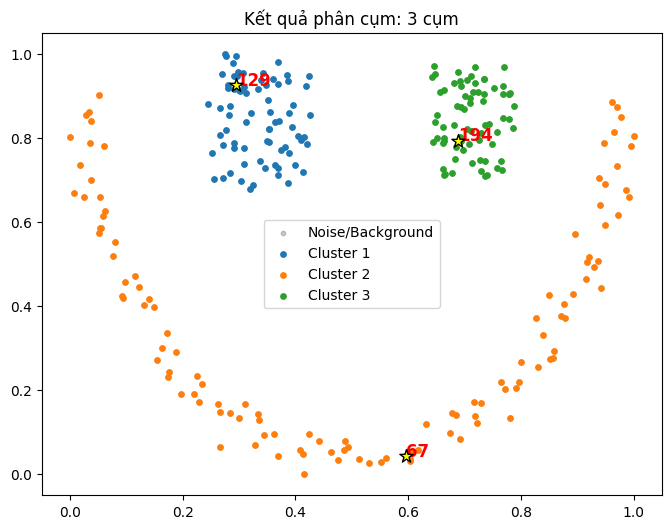

Thời gian chạy: 12.2458s


In [33]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # ==================== TÍNH MẬT ĐỘ CỤC BỘ ====================
    rho = WMKNNDensity(dist, K)

    # ==================== TÍNH DELTA ====================
    delta, neighh = compute_delta(dist, rho)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
DataName = 'smile.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = 10
datamat = scipy.io.loadmat(DataName)
data = datamat['attribute'].tolist()
# Chuẩn hóa
data, model = libsvm_scale(data, 0, 1)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data] for row_i in data]

print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


Data set: D31.mat | Samples: 3100
Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.


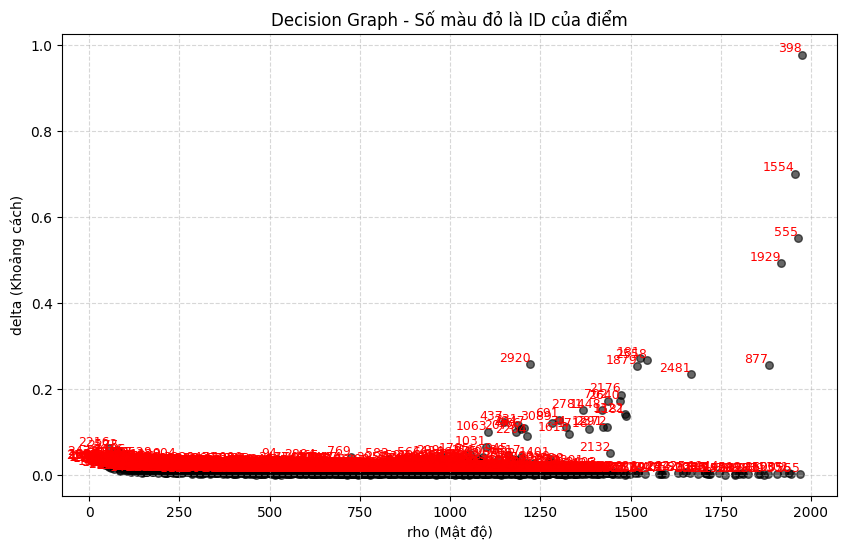

--------------------------------------------------
NHẬP TÂM CỤM:


KeyboardInterrupt: Interrupted by user

In [34]:
## import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # ==================== TÍNH MẬT ĐỘ CỤC BỘ ====================
    rho = WMKNNDensity(dist, K)

    # ==================== TÍNH DELTA ====================
    delta, neighh = compute_delta(dist, rho)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
DataName = 'D31.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = 10
datamat = scipy.io.loadmat(DataName)
data = datamat['attribute'].tolist()
# Chuẩn hóa
data, model = libsvm_scale(data, 0, 1)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data] for row_i in data]

print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


 3



==================== BẢNG DỮ LIỆU CHUẨN HOÁ ====================
ID   | X          | Y         
------------------------------
0    | 0.0000     | 0.0238    
1    | 0.0556     | 0.0476    
2    | 0.0222     | 0.0000    
3    | 0.4444     | 0.5000    
4    | 0.5000     | 0.5357    
5    | 0.4667     | 0.4762    
6    | 0.8889     | 0.9762    
7    | 0.9444     | 1.0000    
8    | 0.4444     | 0.0238    
9    | 1.0000     | 0.5000    

==================== MA TRẬN KHOẢNG CÁCH ====================
[[0.         0.06044264 0.03256871 0.65137411 0.71557423 0.64994331
  1.30274822 1.35827948 0.44444444 1.1075908 ]
 [0.06044264 0.         0.05812646 0.59655938 0.66012713 0.59387357
  1.24767357 1.30274822 0.38961707 1.04719809]
 [0.03256871 0.05812646 0.         0.65442464 0.71781711 0.65137411
  1.30539609 1.36032857 0.42289301 1.0982028 ]
 [0.65137411 0.59655938 0.65442464 0.         0.06604491 0.03256871
  0.65137411 0.70710678 0.47619048 0.55555556]
 [0.71557423 0.66012713 0.71781711 0.06

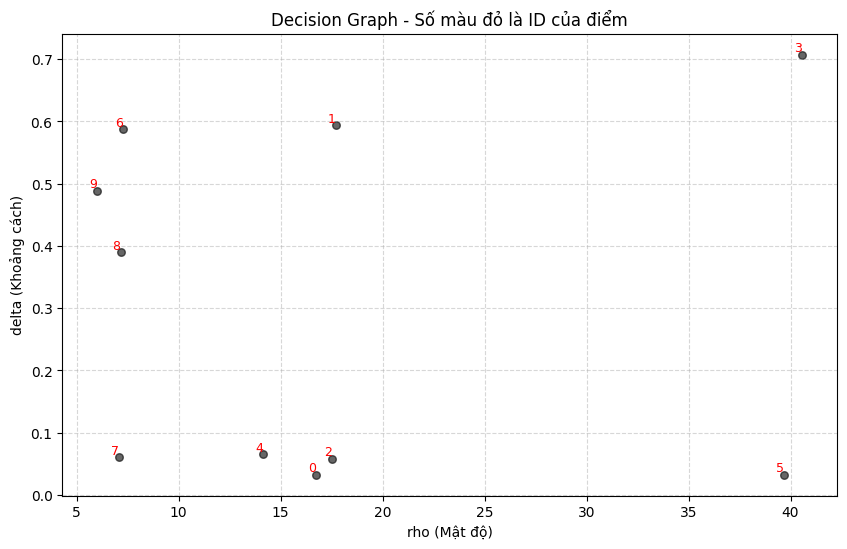

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  3, 1


Các tâm cụm đã chọn: [3, 1]


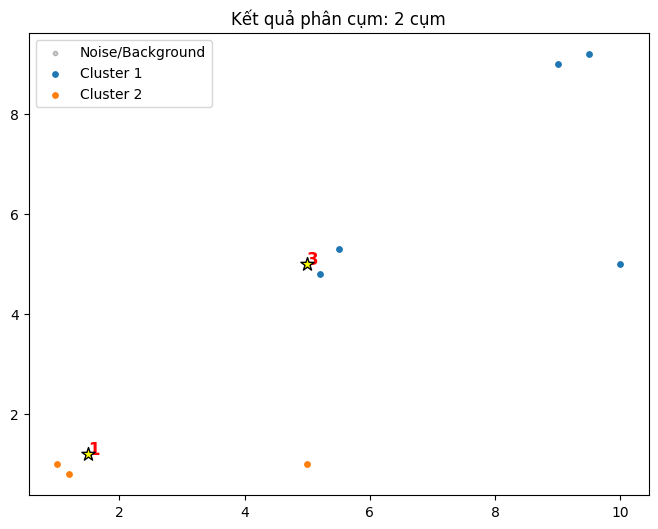

Thời gian chạy: 9.7975s


In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # --- THÊM: IN MA TRẬN KHOẢNG CÁCH ---
    print("\n" + "="*20 + " MA TRẬN KHOẢNG CÁCH " + "="*20)
    print(np.array(dist))
    print("="*60)

    # ==================== TÍNH MẬT ĐỘ & DELTA ====================
    rho = WMKNNDensity(dist, K)
    delta, neighh = compute_delta(dist, rho)

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # --- THÊM: IN CÁC ĐIỂM OUTLIER ---
    outlier_indices = [i for i, label in enumerate(OutlierLabel) if label == 1]
    print(f"Dãy các điểm Outlier (Index): {outlier_indices}")

    # ==================== TÍNH MKNN ====================
    # Gọi hàm để lấy dữ liệu MKNN
    MKNN_raw, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)
    
    # --- THÊM: TÍNH LẠI RNN ĐỂ IN (VÌ HÀM get_mknn KHÔNG TRẢ VỀ RNN) ---
    RNN_raw = get_rnn(MKNN_raw)

    # --- THÊM: IN KNN, RNN, MKNN ---
    print("\n" + "="*20 + " DANH SÁCH HÀNG XÓM " + "="*20)
    print(f"{'ID':<4} | {'KNN':<20} | {'RNN':<20} | {'MKNN':<20}")
    print("-" * 75)
    for i in range(N):
        print(f"{i:<4} | {str(MKNN_raw[i]):<20} | {str(RNN_raw[i]):<20} | {str(intersect_MKNN[i]):<20}")
    print("="*75)

    # --- THÊM: IN BẢNG RHO, DELTA, GAMMA ---
    gamma_graph = [r * d for r, d in zip(rho, delta)]
    print("\n" + "="*20 + " BẢNG RHO - DELTA - GAMMA " + "="*20)
    print(f"{'ID':<4} | {'Rho':<10} | {'Delta':<10} | {'Gamma':<10}")
    print("-" * 45)
    for i in range(N):
        print(f"{i:<4} | {rho[i]:<10.4f} | {delta[i]:<10.4f} | {gamma_graph[i]:<10.4f}")
    print("="*45)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
# DataName = 'D31.mat' # Đảm bảo file này nằm cùng thư mục hoặc đường dẫn đúng
K = int(input())
# datamat = scipy.io.loadmat(DataName)
# data = datamat['attribute'].tolist()
data = [
            [1.0, 1.0],
            [1.5, 1.2],
            [1.2, 0.8],
            [5.0, 5.0],
            [5.5, 5.3],
            [5.2, 4.8],
            [9.0, 9.0],
            [9.5, 9.2],
            [5.0, 1.0],   
            [10.0, 5.0]   
        ]
# --- THÊM: IN BẢNG DỮ LIỆU ĐÃ CHUẨN HOÁ ---
data_scaled, model = libsvm_scale(data, 0, 1)
print("\n" + "="*20 + " BẢNG DỮ LIỆU CHUẨN HOÁ " + "="*20)
print(f"{'ID':<4} | {'X':<10} | {'Y':<10}")
print("-" * 30)
for i, row in enumerate(data_scaled):
    print(f"{i:<4} | {row[0]:<10.4f} | {row[1]:<10.4f}")
    print("="*30)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data_scaled] for row_i in data_scaled]

# print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")


 3



==================== BẢNG DỮ LIỆU CHUẨN HOÁ ====================
ID   | X          | Y         
------------------------------
0    | 0.0000     | 0.0000    
1    | 0.0200     | 0.0000    
2    | 0.0400     | 0.0000    
3    | 0.0240     | 0.1000    
4    | 0.2000     | 0.2000    
5    | 0.2200     | 0.2000    
6    | 1.0000     | 1.0000    

==================== MA TRẬN KHOẢNG CÁCH ====================
[[0.         0.02       0.04       0.10283968 0.28284271 0.29732137
  1.41421356]
 [0.02       0.         0.02       0.10007997 0.26907248 0.28284271
  1.40014285]
 [0.04       0.02       0.         0.10127191 0.25612497 0.26907248
  1.38621788]
 [0.10283968 0.10007997 0.10127191 0.         0.20242529 0.22003636
  1.32762043]
 [0.28284271 0.26907248 0.25612497 0.20242529 0.         0.02
  1.13137085]
 [0.29732137 0.28284271 0.26907248 0.22003636 0.02       0.
  1.11731822]
 [1.41421356 1.40014285 1.38621788 1.32762043 1.13137085 1.11731822
  0.        ]]
Dãy các điểm Outlier (Index): [

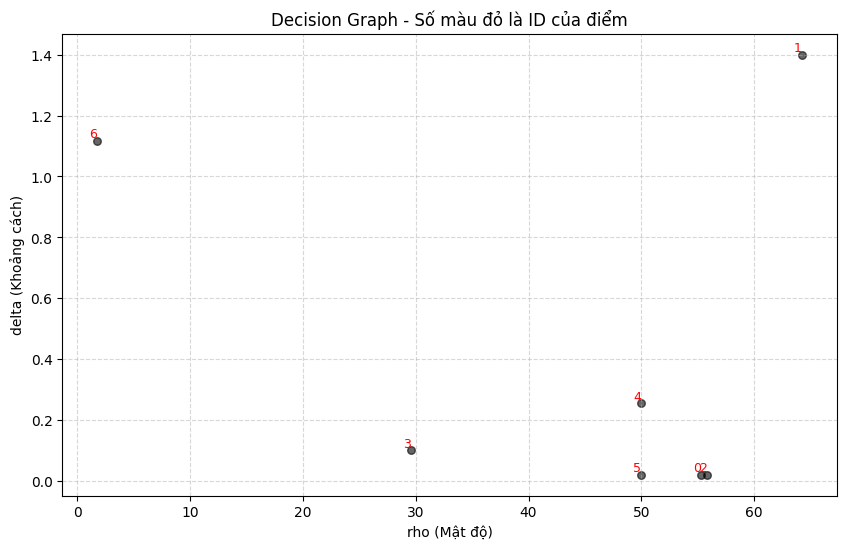

--------------------------------------------------
NHẬP TÂM CỤM:


>>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45):  1, 4


Các tâm cụm đã chọn: [1, 4]


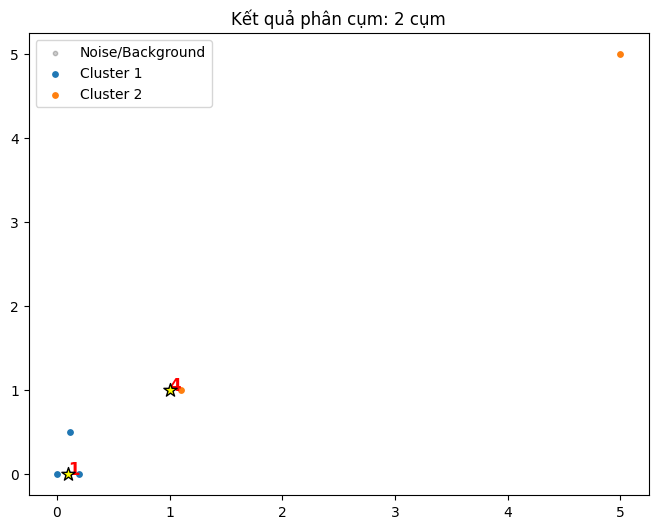

Thời gian chạy: 18.4167s


In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
def libsvm_scale(data, lower=0.0, upper=1.0):
    X = np.asarray(data, dtype=float)

    if X.size == 0:
        return [], {}

    cmin = X.min(axis=0)
    cmax = X.max(axis=0)
    denom = cmax - cmin

    # Tránh chia cho 0: cột hằng → scale về lower
    denom_safe = np.where(denom == 0, 1, denom)

    X_scaled = lower + (upper - lower) * (X - cmin) / denom_safe
    X_scaled[:, denom == 0] = lower

    model = {
        "min": cmin,
        "max": cmax,
        "lower": lower,
        "upper": upper
    }

    return X_scaled.tolist(), model

def get_knn(dist, K):
    ND = len(dist)
    KNN = []

    for i in range(ND):
        ord_idx = sorted(range(ND), key=lambda j: dist[i][j])
        KNN.append(ord_idx[1:K+1])  # bỏ chính nó

    return KNN

def get_rnn(KNN):
    ND = len(KNN)
    RNN = [[] for _ in range(ND)]

    for i in range(ND):
        for j in range(ND):
            if i in KNN[j]:
                RNN[i].append(j)

    return RNN

def get_mknn(dist, K):
    ND = len(dist)

    KNN = get_knn(dist, K)
    RNN = get_rnn(KNN)

    intersect_MKNN = [[] for _ in range(ND)]
    dis_intersect_MKNN = [[] for _ in range(ND)]
    iCount = [0] * ND

    for i in range(ND):
        # giao KNN và RNN, giữ thứ tự KNN
        mutual = [x for x in KNN[i] if x in RNN[i]]

        # fallback: nếu rỗng → lấy nửa KNN
        if not mutual:
            half = (K + 1) // 2
            mutual = KNN[i][:half]

        intersect_MKNN[i] = mutual
        iCount[i] = len(mutual)
        dis_intersect_MKNN[i] = [dist[i][j] for j in mutual]

    return KNN, iCount, intersect_MKNN, dis_intersect_MKNN

def WMKNNDensity(dist, K):
    # Lấy MKNN
    _, _, intersect_MKNN, _ = get_mknn(dist, K)

    ND = len(dist)
    rho = [0.0] * ND

    for i in range(ND):
        neighbors = intersect_MKNN[i]
        cnt = len(neighbors)

        if cnt == 0:
            rho[i] = 0.0
            continue

        # Tổng khoảng cách tới các láng giềng tương hỗ
        total_dist = sum(dist[i][j] for j in neighbors)

        # rho(i) = iCount^2 / sum(dist)
        rho[i] = (cnt * cnt) / total_dist if total_dist > 0 else 0.0

    return rho

def compute_delta(dist, rho):
    N = len(rho)
    delta = [0.0] * N
    nneigh = [-1] * N

    ordrho = sorted(range(N), key=lambda x: rho[x], reverse=True)
    
    # Điểm có rho lớn nhất
    first = ordrho[0]
    delta[first] = max(dist[first])

    # Các điểm còn lại
    for ii in range(1, N):
        i = ordrho[ii]
        prev = ordrho[:ii]

        # tìm điểm gần nhất trong tập có rho cao hơn
        min_dist = float("inf")
        min_idx = -1

        for j in prev:
            if dist[i][j] < min_dist:
                min_dist = dist[i][j]
                min_idx = j

        delta[i] = min_dist
        nneigh[i] = min_idx

    return delta, nneigh

def FKNNOutliers(dist, K):
    N = len(dist)
    delta = [0.0] * N

    # ==================== TÍNH DELTA ====================
    for i in range(N):
        # sắp xếp theo khoảng cách
        ord_idx = sorted(range(N), key=lambda j: dist[i][j])

        # KNN (bỏ chính nó)
        knn = ord_idx[1:K+1]

        # khoảng cách lớn nhất trong KNN
        delta[i] = max(dist[i][j] for j in knn)

    # ==================== NGƯỠNG ====================
    tao = sum(delta) / N

    # ==================== GÁN NHÃN ====================
    outlierLabel = [1 if d > tao else 0 for d in delta]

    return outlierLabel

def KNNC(classlabel, dist, iCount, cn, outlier, intersect_MKNN):
    CL = classlabel.copy()
    label = CL[cn]

    ord1 = intersect_MKNN[cn]
    K = iCount[cn]

    Q = []
    k = 0

    for i in range(K):
        num = ord1[i]
        if CL[num] == 0:
            CL[num] = label
            Q.append(num)
            k += 1

    return Q, CL

def KNNQue(classlabel, dist, iCount, outlier, que, intersect_MKNN):
    CL = classlabel.copy()
    p = que.pop(0)       # lấy điểm đầu
    label = CL[p]

    K = iCount[p]
    KNNP = intersect_MKNN[p][:K]

    for q in KNNP:
        if CL[q] == 0 and outlier[q] == 0:
            # khoảng cách trung bình của KNN q
            KNN_q = intersect_MKNN[q][:iCount[q]]
            dis = sum(dist[q][idx] for idx in KNN_q) / max(1, len(KNN_q))
            if dist[p][q] <= dis:
                CL[q] = label
                que.append(q)

    return que, CL

def WMKNNDPC_AS_First(CI, dist, outlier, K):

    N = len(dist)
    ClassLabel = [0] * N           # 0 = chưa gán lớp
    Cluster = len(CI)              # số lượng cụm

    # Gán lớp cho điểm tâm
    for i, ci in enumerate(CI):
        ClassLabel[ci] = i + 1    # nhãn lớp 1-based

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Gán lớp cho từng cụm
    for i, ci in enumerate(CI):
        Que, ClassLabel = KNNC(ClassLabel, dist, iCount, ci, outlier, intersect_MKNN)
        while Que:
            Que, ClassLabel = KNNQue(ClassLabel, dist, iCount, outlier, Que, intersect_MKNN)

    return ClassLabel

def Membership(p, classlabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    """
    Tính độ trực thuộc lớp của điểm p
    """
    val = [0.0] * cluster
    MKNNP = intersect_MKNN[p]
    MKNNpdis = dis_intersect_MKNN[p]

    for i, j in enumerate(MKNNP):
        cl = classlabel[j]
        if cl != 0:
            Wpj = 1.0 / (1.0 + MKNNpdis[i])
            ds = dis_intersect_MKNN[j]
            Gpj = Wpj / sum([1.0 / (1.0 + d) for d in ds]) if ds else 0
            val[cl - 1] += Gpj * Wpj

    return val

def HighestP(VA):
    max_val = max(VA)
    if max_val > 0:
        return True, VA.index(max_val)
    else:
        return False, -1

def UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN):
    m = len(A)
    Pn = Nom[p]
    MKNNpdis = dis_intersect_MKNN[Pn]
    MKNNspdis = sum([1.0 / (1.0 + d) for d in MKNNpdis]) if MKNNpdis else 1.0

    plabel = VP[p]
    VA[p] = 0
    VP[p] = -1

    for i in range(m):
        if VP[i] != -1:
            # kiểm tra Pn có trong KNN của Nom[i]
            KNN_i = intersect_MKNN[Nom[i]]
            if Pn in KNN_i:
                loc = KNN_i.index(Pn)
                Wqp = 1.0 / (1.0 + dis_intersect_MKNN[Nom[i]][loc])
                Gqp = Wqp / MKNNspdis
                A[i][plabel] += Gqp * Wqp
                VA[i] = max(A[i])
                VP[i] = A[i].index(VA[i])

    return A, VA, VP

def WMKNNDPC_AS_Second(classlabel, CI, K, dist):
    """
    Chiến lược phân bổ WMKNNDPC số 2
    """
    N = len(classlabel)
    ClassLabel = classlabel.copy()

    # Lấy MKNN
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # Các điểm chưa được đánh dấu
    Nom = [idx for idx, val in enumerate(ClassLabel) if val == 0]
    m = len(Nom)

    if m == 0:
        return ClassLabel

    cluster = len(CI)
    A = [[0.0 for _ in range(cluster)] for _ in range(m)]
    VA = [0.0] * m
    VP = [0] * m
    invNom = [0] * N
    for i, idx in enumerate(Nom):
        invNom[idx] = i
        A[i] = Membership(idx, ClassLabel, cluster, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        VA[i] = max(A[i])
        VP[i] = A[i].index(VA[i])

    bool_flag, p = HighestP(VA)

    while bool_flag:
        ClassLabel[Nom[p]] = VP[p] + 1   # nhãn lớp 1-based
        A, VA, VP = UpdateA(p, A, Nom, VA, VP, K, iCount, intersect_MKNN, dis_intersect_MKNN)
        bool_flag, p = HighestP(VA)

    return ClassLabel

def AssignStrategy3(classlabel, MKNN):
    ClassLabel = classlabel.copy()
    N = len(ClassLabel)

    if sum(1 for x in ClassLabel if x == 0) != 0:
        for i in range(N):
            if ClassLabel[i] == 0:
                bool_flag = True
                j = 0
                while bool_flag and j < len(MKNN[i]):
                    if ClassLabel[MKNN[i][j]] != 0:
                        ClassLabel[i] = ClassLabel[MKNN[i][j]]
                        bool_flag = False
                    else:
                        j += 1

    return ClassLabel

def WMKNNDPCF(dist, K):
    start_time = time.time()
    N = len(dist)

    # --- THÊM: IN MA TRẬN KHOẢNG CÁCH ---
    print("\n" + "="*20 + " MA TRẬN KHOẢNG CÁCH " + "="*20)
    print(np.array(dist))
    print("="*60)

    # ==================== TÍNH MẬT ĐỘ & DELTA ====================
    rho = WMKNNDensity(dist, K)
    delta, neighh = compute_delta(dist, rho)

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # --- THÊM: IN CÁC ĐIỂM OUTLIER ---
    outlier_indices = [i for i, label in enumerate(OutlierLabel) if label == 1]
    print(f"Dãy các điểm Outlier (Index): {outlier_indices}")

    # ==================== TÍNH MKNN ====================
    # Gọi hàm để lấy dữ liệu MKNN
    MKNN_raw, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)
    
    # --- THÊM: TÍNH LẠI RNN ĐỂ IN (VÌ HÀM get_mknn KHÔNG TRẢ VỀ RNN) ---
    RNN_raw = get_rnn(MKNN_raw)

    # --- THÊM: IN KNN, RNN, MKNN ---
    print("\n" + "="*20 + " DANH SÁCH HÀNG XÓM " + "="*20)
    print(f"{'ID':<4} | {'KNN':<20} | {'RNN':<20} | {'MKNN':<20}")
    print("-" * 75)
    for i in range(N):
        print(f"{i:<4} | {str(MKNN_raw[i]):<20} | {str(RNN_raw[i]):<20} | {str(intersect_MKNN[i]):<20}")
    print("="*75)

    # --- THÊM: IN BẢNG RHO, DELTA, GAMMA ---
    gamma_graph = [r * d for r, d in zip(rho, delta)]
    print("\n" + "="*20 + " BẢNG RHO - DELTA - GAMMA " + "="*20)
    print(f"{'ID':<4} | {'Rho':<10} | {'Delta':<10} | {'Gamma':<10}")
    print("-" * 45)
    for i in range(N):
        print(f"{i:<4} | {rho[i]:<10.4f} | {delta[i]:<10.4f} | {gamma_graph[i]:<10.4f}")
    print("="*45)

    # ==================== VẼ DECISION GRAPH (KÈM INDEX) ====================
    print("Đang vẽ Decision Graph... Hãy nhìn biểu đồ để chọn ID tâm cụm.")
    fig_cluster, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(rho, delta, s=30, c='k', alpha=0.6)
    
    # Hiển thị số thứ tự (index) bên cạnh mỗi điểm
    # Chỉ hiện index cho những điểm có rho hoặc delta tương đối lớn để đỡ rối mắt
    # (Hoặc hiện hết nếu dữ liệu ít)
    threshold_rho = min(rho) # Hiện tất cả (bạn có thể chỉnh ngưỡng này nếu quá rối)
    
    for i in range(N):
        if rho[i] >= threshold_rho: 
            ax.text(rho[i], delta[i], str(i), fontsize=9, color='red', 
                    verticalalignment='bottom', horizontalalignment='right')

    ax.set_xlabel('rho (Mật độ)')
    ax.set_ylabel('delta (Khoảng cách)')
    ax.set_title('Decision Graph - Số màu đỏ là ID của điểm')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==================== NHẬP TÂM CỤM THỦ CÔNG ====================
    print("-" * 50)
    print("NHẬP TÂM CỤM:")
    user_input = input(">>> Nhập ID các điểm làm tâm (cách nhau bởi dấu phẩy, vd: 10, 45): ")
    
    try:
        # Xử lý chuỗi nhập vào: tách dấu phẩy, xóa khoảng trắng, chuyển thành int
        icl = [int(x.strip()) for x in user_input.split(',') if x.strip().isdigit()]
        
        if not icl:
            print("Cảnh báo: Không có tâm cụm nào được chọn. Chương trình có thể lỗi.")
            icl = [ordrho[0]] # Fallback: lấy điểm có mật độ cao nhất
            print(f"Đã tự động chọn điểm {icl[0]} làm tâm.")
            
    except ValueError:
        print("Lỗi nhập liệu! Đang sử dụng tâm mặc định (điểm mật độ cao nhất).")
        icl = [ordrho[0]]

    print(f"Các tâm cụm đã chọn: {icl}")
    NCLUST = len(icl)
    cl = [-1] * N # -1 là chưa gán nhãn

    # ==================== TÍNH OUTLIERS ====================
    OutlierLabel = FKNNOutliers(dist, K)

    # ==================== TÍNH MKNN ====================
    MKNN, iCount, intersect_MKNN, dis_intersect_MKNN = get_mknn(dist, K)

    # ==================== STRATEGY 1 ====================
    # Hàm này sẽ gán nhãn dựa trên danh sách icl (tâm cụm) đầu vào
    cl = WMKNNDPC_AS_First(icl, dist, OutlierLabel, K)

    # ==================== STRATEGY 2 ====================
    cl = WMKNNDPC_AS_Second(cl, icl, K, dist)

    # ==================== STRATEGY 3 ====================
    KNNA = []
    for i in range(N):
        KNNA.append(sorted(range(N), key=lambda j: dist[i][j]))
    cl = AssignStrategy3(cl, KNNA)

    end_time = time.time()
    elapsed_time = round(end_time - start_time, 4)

    return cl, icl, elapsed_time

# ==================== Load dữ liệu & Chạy ====================
AlgorithmName = 'WMKNNDPC'
K = int(input())
 data = [
    (0, 0),      # A
    (0.1, 0),    # B
    (0.2, 0),    # C
    (0.12, 0.5), # D
    (1, 1),      # E
    (1.1, 1),    # F
    (5, 5)       # G
    ]
# --- THÊM: IN BẢNG DỮ LIỆU ĐÃ CHUẨN HOÁ ---
data_scaled, model = libsvm_scale(data, 0, 1)
print("\n" + "="*20 + " BẢNG DỮ LIỆU CHUẨN HOÁ " + "="*20)
print(f"{'ID':<4} | {'X':<10} | {'Y':<10}")
print("-" * 30)
for i, row in enumerate(data_scaled):
    print(f"{i:<4} | {row[0]:<10.4f} | {row[1]:<10.4f}")
    print("="*30)

# Tính khoảng cách
dist = [[sum((xi - xj) ** 2 for xi, xj in zip(row_i, row_j)) ** 0.5
        for row_j in data_scaled] for row_i in data_scaled]

# print(f'Data set: {DataName} | Samples: {len(data)}')

# --- GỌI HÀM PHÂN CỤM (Sẽ hiển thị biểu đồ và chờ bạn nhập) ---
cl, icl, elapsed_time = WMKNNDPCF(dist, K)

# ==================== Vẽ kết quả phân cụm ====================
if len(data[0]) == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter([row[0] for row in data], [row[1] for row in data],
                s=10, c='k', alpha=0.2, label='Noise/Background')
        
    NCLUST = len(icl)
    if NCLUST > 0:
        cmap = plt.colormaps['tab10'] 
            
        for i in range(NCLUST):
            # Lấy các điểm thuộc cluster i+1
            cluster_points = [idx for idx, val in enumerate(cl) if val == i + 1]
            if not cluster_points: continue
                
            Ax = [data[idx][0] for idx in cluster_points]
            Ay = [data[idx][1] for idx in cluster_points]

            color = cmap(i)
            plt.scatter(Ax, Ay, s=15, color=color, label=f'Cluster {i+1}')
                
            # Vẽ và đánh dấu tâm cụm
            center_idx = icl[i]
            plt.scatter(data[center_idx][0], data[center_idx][1], 
                    s=100, marker='*', color='yellow', edgecolors='black', zorder=10)
            plt.text(data[center_idx][0], data[center_idx][1], str(center_idx), 
                    fontsize=12, fontweight='bold', color='red')

    plt.title(f'Kết quả phân cụm: {len(icl)} cụm')
    plt.legend()
    plt.show()
    
print(f"Thời gian chạy: {elapsed_time}s")
